In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:

# define ANN structure
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_Tanh_stack = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1),
        )

    def forward(self, x):
        logits = self.linear_Tanh_stack(x)
        return logits
# define PINN structure
class PINN():
    def __init__(self,t_axis, x_axis, IC_func,iter_nums=1000):
        # accounting for scale change by normalization
        self.t_min_max = [t_axis.min(),t_axis.max()]
        self.x_min_max = [x_axis.min(),x_axis.max()]
        self.t_grad_scale = torch.tensor(1/(t_axis.max()-t_axis.min())).to(device) 
        self.x_grad_scale = torch.tensor(1/(x_axis.max()-x_axis.min())).to(device) 
        
        # initialization grids from regular x and t
        # Collocation points 
        t_axis_nor,x_axis_nor = self.coordination_normalization(t_axis,x_axis)
        self.tx_col = self.cartesian_coord_to_ij(t_axis_nor, x_axis_nor) 
        # BC points
        self.BC_tx_l  = self.cartesian_coord_to_ij(t_axis_nor, x_axis_nor[ 0])
        self.BC_tx_r  = self.cartesian_coord_to_ij(t_axis_nor, x_axis_nor[-1])  
        # IC points 
        IC_expected = IC_func(x_axis) # x before normalization
        self.IC_tx  = self.cartesian_coord_to_ij(t_axis_nor[0], x_axis_nor)
        self.IC_expected = torch.tensor(IC_expected[:,None]).to(device) 
        # Collocation points with require gradient = True
        self.tx_col.requires_grad  = True
        self.BC_tx_l.requires_grad = True
        self.BC_tx_r.requires_grad = True
     # initial ANN
        self.NN_model = NeuralNetwork().to(device)
#         self.optimizer = torch.optim.SGD(self.NN_model.parameters(),lr=0.01)
        self.optimizer = torch.optim.Adam(self.NN_model.parameters(), lr=0.002, betas=(0.9, 0.999))

    def cartesian_coord_to_ij(self, t_axis, x_axis):
        t_col,x_col = np.meshgrid(t_axis, x_axis, indexing='ij') 
        # time & space mesh in rows
        tx_col = np.concatenate((t_col.reshape(-1,1), x_col.reshape(-1,1)), 
                                axis=1,dtype='float32')
        return torch.tensor(tx_col).to(device) 

    def coordination_normalization(self,t_axis,x_axis):
        t_axis_nor = (t_axis-self.t_min_max[0])*self.t_grad_scale.item()-0.5
        x_axis_nor = (x_axis-self.x_min_max[0])*self.x_grad_scale.item()-0.5
        return t_axis_nor,x_axis_nor 

    # define loss function
    def output_gradient(self,tx_col):
        output = self.NN_model(tx_col)
        output_tx = torch.autograd.grad(output,tx_col,grad_outputs=torch.ones_like(output), 
                                        create_graph=True)[0]
        return output_tx

    def loss_PDE(self,tx_col):
        output_tx = self.output_gradient(tx_col)
        # PDE:
        # \frac{\partial A}{\partial t} + u*\frac{\partial A}{\partial x} = 0
        u = torch.tensor(1.0, requires_grad=True).to(device)
        LHS = output_tx[:,0] * self.t_grad_scale # partial t
        RHS = - u * output_tx[:,1] * self.x_grad_scale # partial x
        loss_fn = torch.nn.MSELoss()(LHS, RHS)
        return loss_fn

    def loss_BC(self):
        # setup periodic B.C. via loss function
        # (mixed type with derivative periodic need to test)
        # 1st type B.C. via loss function
        # periodic values, for t=?, output(x=-1) = output(x=1)
        output_bc_l = self.NN_model(self.BC_tx_l)
        output_bc_r = self.NN_model(self.BC_tx_r)
        loss        = torch.nn.MSELoss()(output_bc_l, output_bc_r)
#         # 2nd B.C. derivative via loss function # need more research
#         # periodic derivative, for t=?, output_xt(x=-1) = output_xt(x=1)
#         output_bc_l_xt = self.output_gradient(self.BC_tx_l)
#         output_bc_r_xt = self.output_gradient(self.BC_tx_r)
#         loss       += torch.nn.MSELoss()(output_bc_l_xt, output_bc_r_xt)
        return loss

    def loss_IC(self):
        # periodic values, for x=?, output(t=0) = IC_expected
        output = self.NN_model(self.IC_tx)
        loss = torch.nn.MSELoss()(output, self.IC_expected)
        return loss
      
    def train_loop(self,iter_nums=None,optimizer=None):
        if optimizer is None:
            optimizer = self.optimizer
        if iter_nums is None:
            iter_nums = self.iter_nums
        for iters in range(iter_nums):
            # Compute loss: function loss + BC/IC loss
            loss1 = self.loss_PDE(self.tx_col) 
            loss2 = self.loss_BC()
            loss3 = self.loss_IC()  
            loss = loss1 + loss2 + 5*loss3
#             loss = loss3
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return [loss1.item(),loss2.item(),loss3.item()]
#         return [loss3.item(),loss3.item(),loss3.item()]
    def predict(self,tx_col=None):
        if tx_col is None:
            tx_col = self.tx_col
        with torch.no_grad():
            output = self.NN_model(tx_col)
        return output

In [5]:
def analytical_results(x_axis,x_new,t_new,IC_func):
    output = np.zeros((t_new.size,x_new.size),dtype='float32')
    for i in range(t_new.size):
        x_tmp =  x_trace_back(x_axis,x_new,t_new[i])
        output[i,:] =  IC_func(x_tmp)
    return output
def x_trace_back(x_axis,x,t):
    xmax = x_axis.max()
    xmin = x_axis.min()
    x_axis_range = xmax-xmin
    x_rev = x-t
    offset = x_rev.max()-xmax
    x_rev = x_rev-int(offset/(x_axis_range))*(x_axis_range)
    x_rev = np.where(np.logical_and(x_rev>=xmin, x_rev<xmax),x_rev,x_rev+x_axis_range)
    return x_rev  

In [28]:
# regular grid
t_axis = np.arange(0,2,0.01,dtype='float32')    # time
x_axis = np.arange(-1,1+1e-3,1e-2,dtype='float32')   # space
# set IC 
def IC_func(x):
#     return np.sin(x*np.pi)
    return np.sign(x)
# def IC_func(x):
#     IC = np.ones_like(x)
#     IC = np.where(np.logical_and(x>=0.0, x<0.5),IC,0)
#     return IC

adv_1d_solver = PINN(t_axis=t_axis, x_axis=x_axis,IC_func=IC_func)


In [29]:
N_save = 20
N_save_num = 200
N_epoch = N_save*N_save_num
predict_iterms = np.zeros((N_save,t_axis.size,x_axis.size),dtype='float32')
loss = []
for i in range(N_epoch):
    # train and get loss: iter_nums per epoch
    loss_tmp = adv_1d_solver.train_loop(iter_nums=1)
    if i%N_save_num == 0:
        print(f'Epoch {i:5d} ' 
             +f'| PDE loss: {loss_tmp[0]:7.5f} '
             +f'| BC loss: {loss_tmp[1]:7.5f} '
             +f'| IC loss: {loss_tmp[2]:7.5f} ')
        loss.append(loss_tmp)
        # predict and save output of NN_model
        output = adv_1d_solver.predict()
        predict_iterms[int(i/N_save_num),:,:] = output.to('cpu').reshape((t_axis.size,x_axis.size))

Epoch     0 | PDE loss: 0.00113 | BC loss: 0.00225 | IC loss: 1.01551 
Epoch   200 | PDE loss: 0.11016 | BC loss: 0.13554 | IC loss: 0.03134 
Epoch   400 | PDE loss: 0.01881 | BC loss: 0.04521 | IC loss: 0.01115 
Epoch   600 | PDE loss: 0.00968 | BC loss: 0.02691 | IC loss: 0.00631 
Epoch   800 | PDE loss: 0.00570 | BC loss: 0.01952 | IC loss: 0.00571 
Epoch  1000 | PDE loss: 0.00428 | BC loss: 0.01974 | IC loss: 0.00234 
Epoch  1200 | PDE loss: 0.00369 | BC loss: 0.01815 | IC loss: 0.00180 
Epoch  1400 | PDE loss: 0.00317 | BC loss: 0.01697 | IC loss: 0.00150 
Epoch  1600 | PDE loss: 0.00273 | BC loss: 0.01610 | IC loss: 0.00132 
Epoch  1800 | PDE loss: 0.00235 | BC loss: 0.01568 | IC loss: 0.00115 
Epoch  2000 | PDE loss: 0.00136 | BC loss: 0.02073 | IC loss: 0.00219 
Epoch  2200 | PDE loss: 0.00170 | BC loss: 0.01512 | IC loss: 0.00110 
Epoch  2400 | PDE loss: 0.00156 | BC loss: 0.01468 | IC loss: 0.00100 
Epoch  2600 | PDE loss: 0.00140 | BC loss: 0.01441 | IC loss: 0.00093 
Epoch 

/tmp/ipykernel_24573/3120935025.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


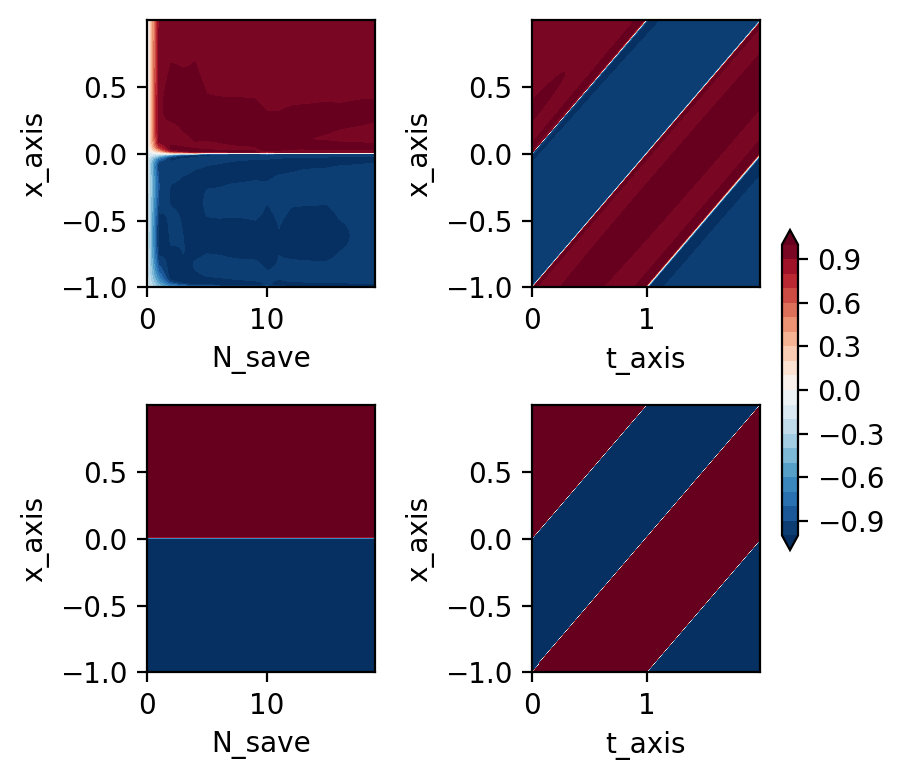

In [72]:
output_truth = analytical_results(x_axis,x_axis,t_axis,IC_func)
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(4,4),dpi=200) 
axs = axs.flatten()
levels = np.arange(-1,1.05,0.1)
ax = axs[0]
ax.contourf(np.arange(N_save),x_axis,predict_iterms[:,0,:].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('N_save')
ax.set_ylabel('x_axis')
ax = axs[1]
ax.contourf(t_axis,x_axis,predict_iterms[-1,:,:].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('t_axis')
ax.set_ylabel('x_axis')
ax = axs[2]
ax.contourf(np.arange(N_save),x_axis,
            np.repeat(output_truth[None,0,:].T, N_save, axis=1),
             levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('N_save')
ax.set_ylabel('x_axis')
ax = axs[3]
cb = ax.contourf(t_axis,x_axis,output_truth.T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('t_axis')
ax.set_ylabel('x_axis')
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
# Draw the colorbar
cbar = fig.colorbar(cb, cax=cbar_ax,orientation='vertical')
fig.tight_layout()

In [102]:
# high resolution output
# regular grid
t_hr = np.arange(0,2,0.01,dtype='float32')    # time
x_hr = np.arange(-1,1+1e-3,1e-3,dtype='float32')   # space
t_hr_nor,x_hr_nor = adv_1d_solver.coordination_normalization(t_hr,x_hr)
hr_tx = adv_1d_solver.cartesian_coord_to_ij(t_hr_nor,x_hr_nor)

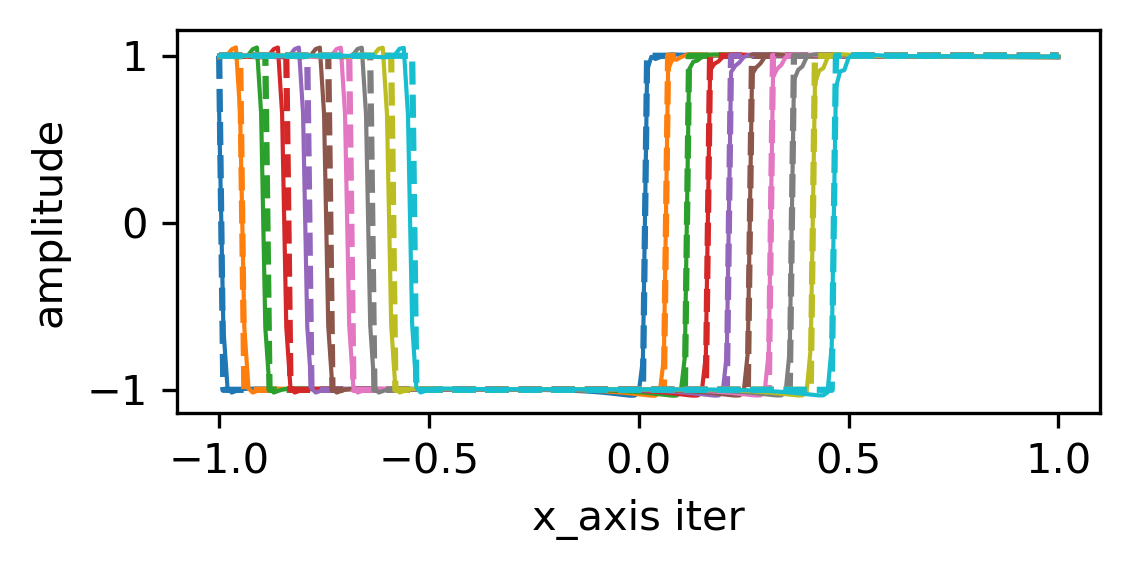

In [105]:
output = adv_1d_solver.predict(hr_tx).to('cpu').reshape((t_hr.size,x_hr.size))
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(4,2),dpi=300) 
ax = axs
for t_i in np.arange(1,50,5):
    p=ax.plot(x_hr,output[t_i,:],linewidth=1,label = f"t = {t_hr[t_i]:4.2f}")
    x_tmp = x_trace_back(x_axis,x_hr,t_hr[t_i])
    ax.plot(x_hr,IC_func(x_tmp),'--',c=p[0].get_color())
# ax.legend()
ax.set_xlabel('x_axis iter')
ax.set_ylabel('amplitude')
fig.tight_layout()